# 1.思考在自然语言处理中如何发掘模型的可解释性

- 可视化中间层
- 测试集中某类别打乱，看哪些打乱，会影响准确率
- 相同类型的向量聚集在一起，变得线性可分，最后加一个线性分类层。 eg：对图形进行降纬，对表示进行降纬。
- 对图像进行遮挡，观察遮挡后，模型效果，见论文《Visualizing and Understanding Convolutional Networks》也是计算机视觉领域大名鼎鼎的一篇论文
- 通过反卷积结果，进行可视化，feature map动态展示出来
- ROC越高，模型越好，AOC面积越大，越好。

# 2.在Seq2Seq和注意力机制中如何可视化模型细节

- 打印出attention计算中的全值向量，在输入序列与输出序列之间建立注意力机制的关联矩阵。

# 3.对抗样本能否运用到自然语言处理模型中

- 对抗样本： 给一个网络加一些噪音，使得网络可以变得指鹿为马
- 可以生成假网络，给一些图像一些看似随机的噪音，就能够糊弄网络去指鹿为马。

# 4.复现Kaggle心脏病数据集冠军kernel，理解所用的模型可解释性技巧

In [2]:
!pip install eli5

### eli5
- 用于处理文本分类的机器学习的库

In [6]:
!pip install shap

    100% |████████████████████████████████| 276kB 56kB/s ta 0:00:01
  Stored in directory: /Users/stone/Library/Caches/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [8]:
!pip install pdpbox

    100% |████████████████████████████████| 57.7MB 301kB/s ta 0:00:011    42% |█████████████▊                  | 24.7MB 96kB/s eta 0:05:44
  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ReadTimeoutError("HTTPSConnectionPool(host='pypi.org', port=443): Read timed out. (read timeout=15)")': /simple/joblib/
    100% |████████████████████████████████| 296kB 8.3MB/s eta 0:00:01
  Stored in directory: /Users/stone/Library/Caches/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [85]:
import numpy as np
import pandas as pd
# 绘图
import matplotlib.pyplot as plt
import seaborn as sns
# 随机森林
from sklearn.ensemble import RandomForestClassifier
# 决策树
from sklearn.tree import DecisionTreeClassifier
# 打印树结构
from sklearn.tree import export_graphviz  # 画决策树
# 评估指标，混淆矩阵
from sklearn.metrics import roc_curve, auc
# 显示主要分类指标的文本报告
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix #for modelx evaluation
from sklearn.model_selection import train_test_split #for data splitting

# 使用统一API可视化调试各种机器学习模型
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots
np.random.seed(123) #ensure reproducibility 重生

pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [41]:
dt = pd.read_csv("data/heart.csv")

In [42]:
dt.head(10) # 前十行

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   
5   57    1   0       140   192    0        1      148      0      0.4      1   
6   56    0   1       140   294    0        0      153      0      1.3      1   
7   44    1   1       120   263    0        1      173      0      0.0      2   
8   52    1   2       172   199    1        1      162      0      0.5      2   
9   57    1   2       150   168    0        1      174      0      1.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
5   0     1       1  
6   0     2       1  
7   0     3       1  
8   0     3       1  
9   0     2       1

In [43]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


## 数据预处理

In [44]:
dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [46]:
dt.columns

Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'cholesterol', 'fasting_blood_sugar', 'rest_ecg',
       'max_heart_rate_achieved', 'exercise_induced_angina', 'st_depression',
       'st_slope', 'num_major_vessels', 'thalassemia', 'target'],
      dtype='object')

数字内容重新调整，便于理解

In [45]:
dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

In [57]:
dt.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [58]:
dt = pd.get_dummies(dt, drop_first=True)

In [59]:
dt.head()

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
0   63                     145          233                      150   
1   37                     130          250                      187   
2   41                     130          204                      172   
3   56                     120          236                      178   
4   57                     120          354                      163   

   st_depression  num_major_vessels  target  sex_male  \
0            2.3                  0       1         1   
1            3.5                  0       1         1   
2            1.4                  0       1         0   
3            0.8                  0       1         1   
4            0.6                  0       1         0   

   chest_pain_type_atypical angina  chest_pain_type_non-anginal pain  \
0                                0                                 1   
1                                1                                 0   
2                                0                                 0   
3                                0                                 0   
4                                0                                 0   

   chest_pain_type_typical angina  fasting_blood_sugar_lower than 120mg/ml  \
0                               0                                        0   
1                               0                                        1   
2                               1                                        1   
3                               1                                        1   
4                               0                                        1   

   rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
0                                      0                1   
1                                      0                0   
2                                      0                1   
3                                      0                0   
4                                      0                0   

   exercise_induced_angina_yes  st_slope_flat  st_slope_upsloping  \
0                            0              0                   0   
1                            0              0                   0   
2                            0              1                   0   
3                            0              1                   0   
4                            1              1                   0   

   thalassemia_fixed defect  thalassemia_normal  thalassemia_reversable defect  
0                         0                   1                              0  
1                         1                   0                              0  
2                         1                   0                              0  
3                         1                   0                              0  
4                         1                   0                              0

## 随机森林模型

In [60]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=10) #split the data

使用最大深度为5的随机森林分类器

In [61]:
model = RandomForestClassifier(max_depth=5)

In [62]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

subprocess模块用来创建新的进程，连接到其stdin、stdout、stderr管道并获取它们的返回码

In [74]:
# 绘图
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from IPython.display import Image
Image(filename = 'tree.png')

#### 预测


In [75]:
y_predict = model.predict(X_test)

In [76]:
y_pred_quant = model.predict_proba(X_test)[:, 1]

In [94]:
X_test

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
246   56                     134          409                      150   
183   58                     112          230                      165   
229   64                     125          309                      131   
126   47                     112          204                      143   
184   50                     150          243                      128   
1     37                     130          250                      187   
59    57                     128          303                      159   
194   60                     140          185                      155   
132   42                     120          295                      162   
175   40                     110          167                      114   
162   41                     120          157                      182   
181   65                     150          225                      114   
296   63                     124          197                      136   
164   38                     138          175                      173   
219   48                     130          256                      150   
92    52                     138          223                      169   
195   59                     170          326                      140   
198   62                     120          267                       99   
24    40                     140          199                      178   
249   69                     140          254                      146   
139   64                     128          263                      105   
26    59                     150          212                      157   
287   57                     154          232                      164   
64    58                     140          211                      165   
202   58                     150          270                      111   
240   70                     160          269                      112   
285   46                     140          311                      120   
186   60                     130          253                      144   
127   67                     152          277                      172   
191   58                     128          216                      131   
..   ...                     ...          ...                      ...   
52    62                     130          231                      146   
279   61                     138          166                      125   
138   57                     110          201                      126   
193   60                     145          282                      142   
207   60                     150          258                      157   
25    71                     160          302                      162   
270   46                     120          249                      144   
105   68                     120          211                      115   
264   54                     110          206                      108   
289   55                     128          205                      130   
169   53                     140          203                      155   
43    53                     130          264                      143   
188   50                     140          233                      163   
80    41                     112          250                      179   
273   58                     100          234                      156   
259   38                     120          231                      182   
56    48                     122          222                      186   
98    43                     130          315                      162   
106   69                     160          234                      131   
173   58                     132          224                      173   
87    46                     101          197                      156   
244   56                     132          184                      105   
213   61 

In [88]:
y_test

246    0
183    0
229    0
126    1
184    0
1      1
59     1
194    0
132    1
175    0
162    1
181    0
296    0
164    1
219    0
92     1
195    0
198    0
24     1
249    0
139    1
26     1
287    0
64     1
202    0
240    0
285    0
186    0
127    1
191    0
      ..
52     1
279    0
138    1
193    0
207    0
25     1
270    0
105    1
264    0
289    0
169    0
43     1
188    0
80     1
273    0
259    0
56     1
98     1
106    1
173    0
87     1
244    0
213    0
36     1
10     1
277    0
121    1
187    0
301    0
283    0
Name: target, Length: 61, dtype: int64

In [90]:
y_predict

array([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1])

In [92]:
y_pred_quant

array([0.0503268 , 0.23366013, 0.28445378, 0.83901368, 0.05588235,
       0.55097436, 0.66106443, 0.89333333, 0.89469995, 0.00588235,
       0.93089043, 0.22126697, 0.48726541, 0.87647059, 0.25576923,
       0.86694678, 0.325     , 0.00588235, 0.30021008, 0.04199346,
       0.07860963, 0.87600886, 0.7494958 , 0.89773109, 0.53730159,
       0.00588235, 0.10588235, 0.15      , 0.83551693, 0.00588235,
       0.90792717, 0.14088235, 0.19718137, 0.32279107, 0.00588235,
       0.04199346, 0.74895129, 0.59989557, 0.73877315, 0.48935606,
       0.00588235, 0.20277778, 0.78076267, 0.56558442, 0.82856209,
       0.60508021, 0.3       , 0.85623886, 0.7333273 , 0.32657509,
       0.375     , 0.83910277, 0.02389706, 0.26445378, 0.93601961,
       0.85175599, 0.87262284, 0.78114082, 0.00588235, 0.06588235,
       0.6410831 ])

#### 混淆矩阵

In [ ]:
？

In [93]:
confusion_matrix = confusion_matrix(y_test, y_predict)
confusion_matrix

TypeError: 'numpy.ndarray' object is not callable

In [95]:
total=sum(sum(confusion_matrix))
print("total", total)
sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

total 61
Sensitivity :  0.84375
Specificity :  0.7241379310344828


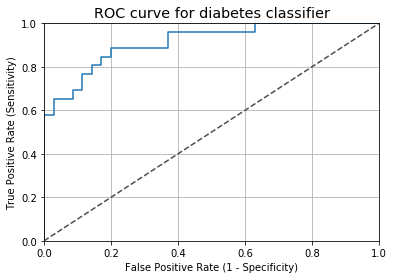

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [96]:
auc(fpr, tpr)

0.9131868131868132

In [97]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

如上图所示：绿色表示正相关，红色表示负相关，颜色越深，权重的绝对值越大，表示相关程度越大，中间权重为0的结果标识修改该特征对于结果没有明显影响。

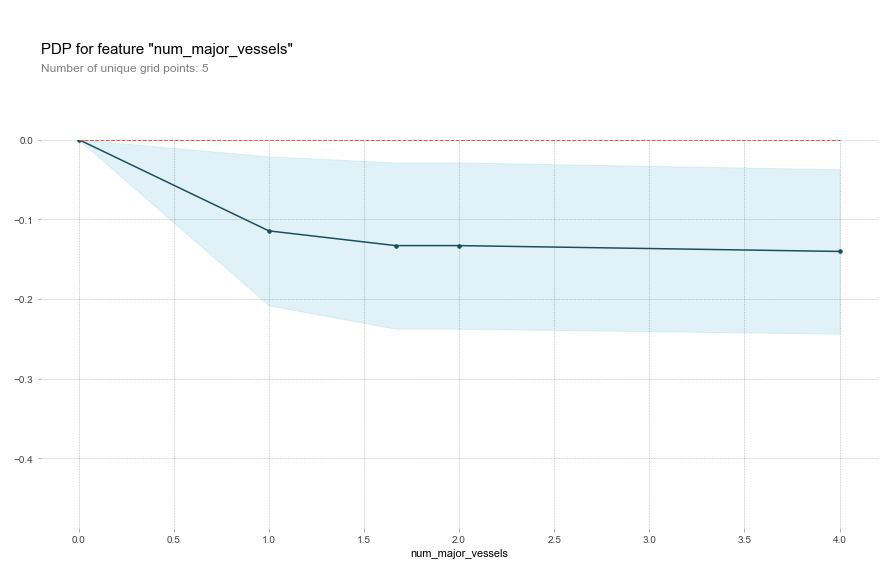

In [98]:
base_features = dt.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

红色虚线是基准线，Y轴表示预测相较于基准线的变化，X轴是主血管数量，蓝色实线表示变化均值，阴影区域表示置信区间。从图上可以看出，主血管数量越多，得心脏病的几率就越小，但是在增加到一定程度后几率就趋于平缓。

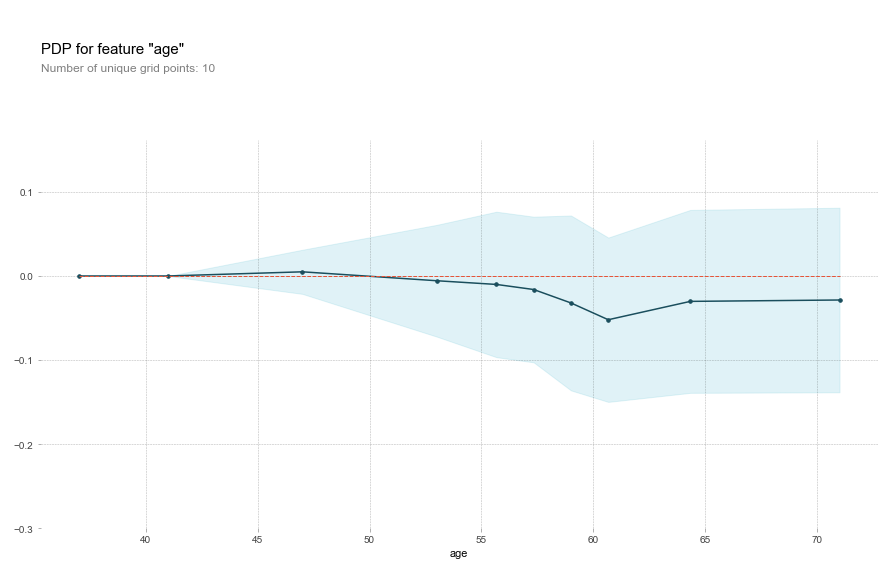

In [99]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

X轴表示年龄，y轴表示得心脏病的几率

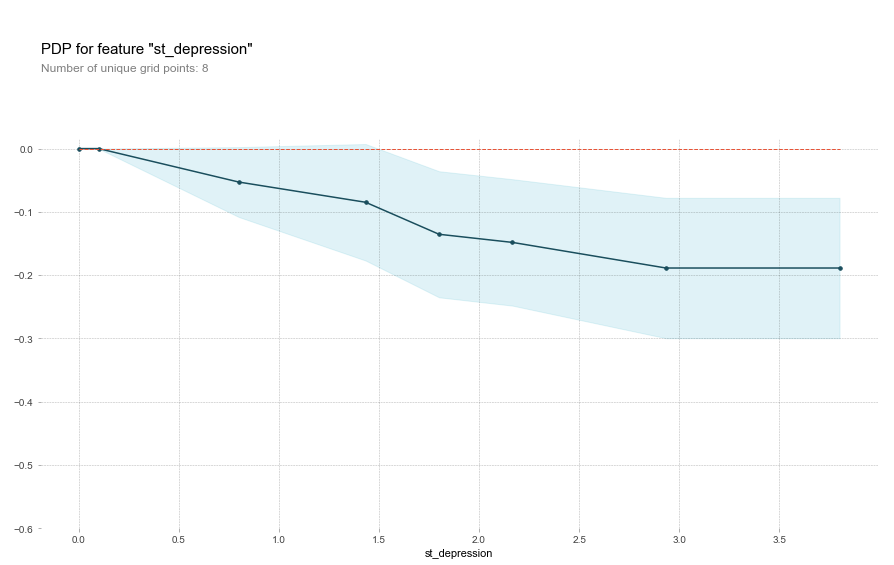

In [100]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

st_depression相关的心脏病患病概率

TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'

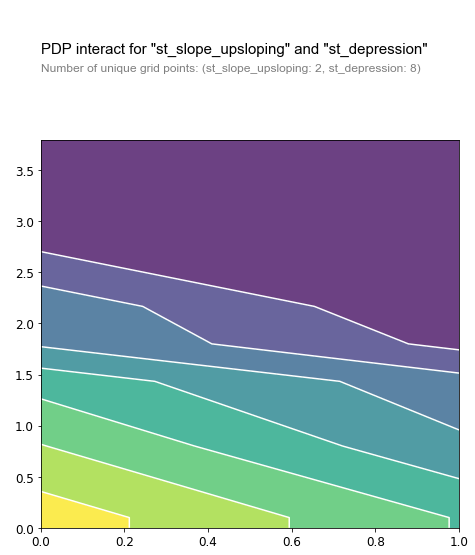

In [102]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()

？

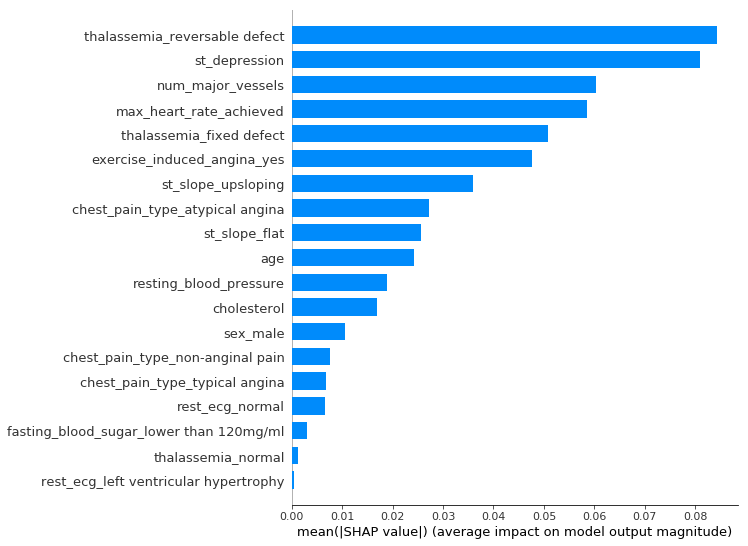

In [104]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

Shap值预测每个特征对于结果的影响

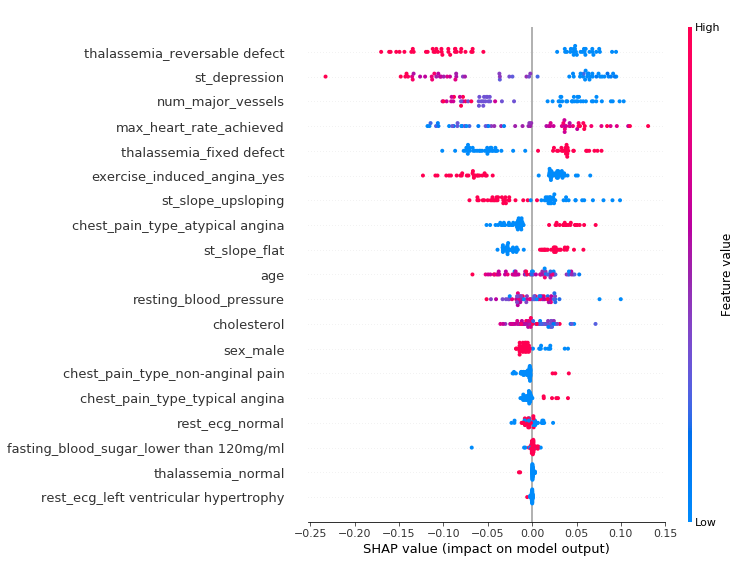

In [105]:
shap.summary_plot(shap_values[1], X_test)

挑选出一些独立的特征进行观察

In [106]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [107]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

In [108]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)